In [8]:
!git clone https://github.com/jaddoescad/ants-bees-dataset

fatal: destination path 'ants-bees-dataset' already exists and is not an empty directory.


In [9]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
transform_train = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),

                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),

                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5,), (0.5,))
                                      ])

transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                                ])

In [12]:
training_dataset = datasets.ImageFolder(root='ants-bees-dataset/train', transform=transform_train)
validation_dataset = datasets.ImageFolder(root='ants-bees-dataset/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, pin_memory=True)

In [13]:
# Corrected im_convert function
def im_convert(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    return image

In [14]:
classes = ('ant', 'bee')

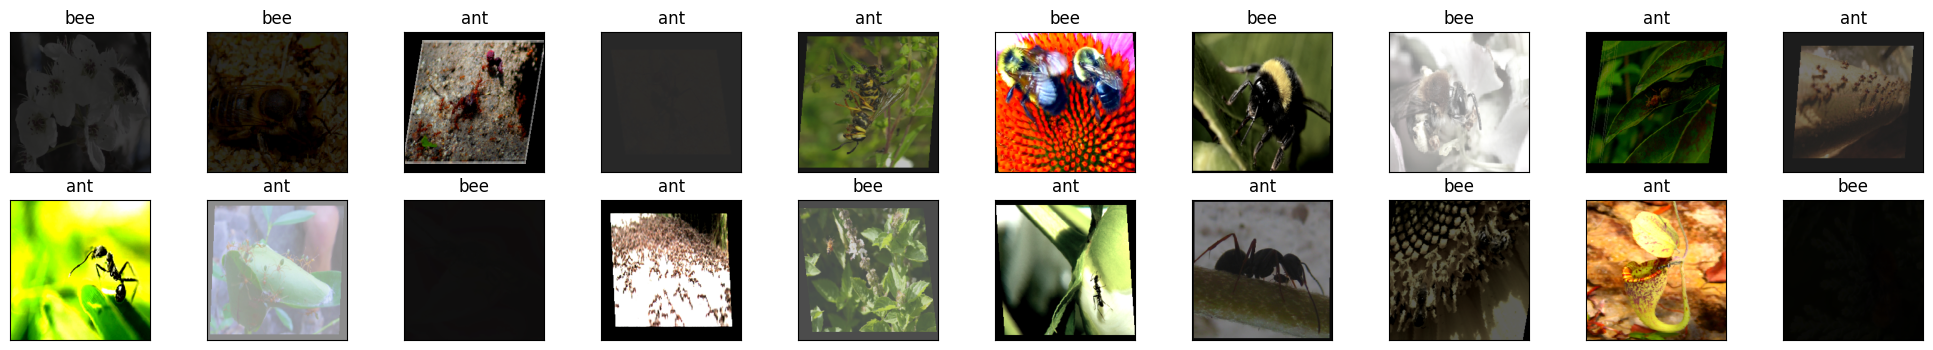

In [15]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [16]:
model = models.alexnet(pretrained=True)

C:\Users\admin\Documents\GitHub\Transfer-Learning-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\Documents\GitHub\Transfer-Learning-PyTorch\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [18]:
for param in model.features.parameters():
    param.requires_grad = False

In [19]:
# replacing last layer of AlexNet with our own layer
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model = model.to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [21]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

    running_loss = 0.0
    running_corrects = 0.0

    val_running_loss = 0.0
    val_running_corrects = 0.0

    for inputs, labels in training_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)


    else:
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        epoch_loss = running_loss / len(training_loader.dataset)
        epoch_accuracy = running_corrects.float() / len(training_loader.dataset)

        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_accuracy)
        # ==========================//test//======================
        val_epoch_loss = val_running_loss / len(validation_loader.dataset)
        val_epoch_accuracy = val_running_corrects.float() / len(validation_loader.dataset)

        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_accuracy)

        print(f'epoch {e + 1}')
        print('training loss:{:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
        print('test loss:{:.4f}, test accuracy {:.4f}'.format(val_epoch_loss, val_epoch_accuracy.item()))

epoch 1
training loss:0.0343, accuracy 0.6025
test loss:0.0203, test accuracy 0.8431
epoch 2
training loss:0.0238, accuracy 0.7910
test loss:0.0188, test accuracy 0.8497
epoch 3
training loss:0.0219, accuracy 0.7951
test loss:0.0178, test accuracy 0.8824
epoch 4
training loss:0.0217, accuracy 0.7664
test loss:0.0169, test accuracy 0.8627
epoch 5
training loss:0.0225, accuracy 0.8074
test loss:0.0142, test accuracy 0.8889
epoch 6
training loss:0.0205, accuracy 0.8279
test loss:0.0233, test accuracy 0.8431
epoch 7
training loss:0.0226, accuracy 0.7787
test loss:0.0153, test accuracy 0.9412
epoch 8
training loss:0.0173, accuracy 0.8443
test loss:0.0166, test accuracy 0.9020
epoch 9
training loss:0.0174, accuracy 0.8648
test loss:0.0205, test accuracy 0.8954
epoch 10
training loss:0.0174, accuracy 0.8402
test loss:0.0178, test accuracy 0.8824


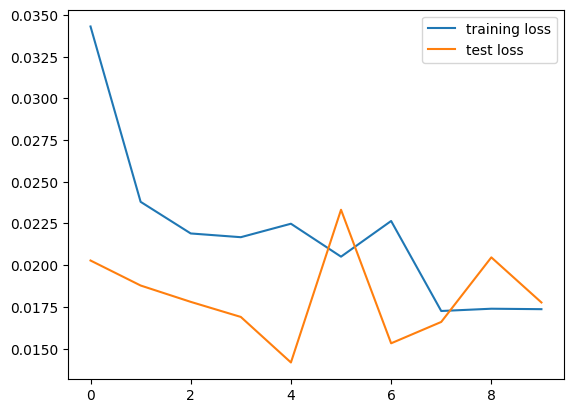

In [22]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='test loss')
plt.legend()

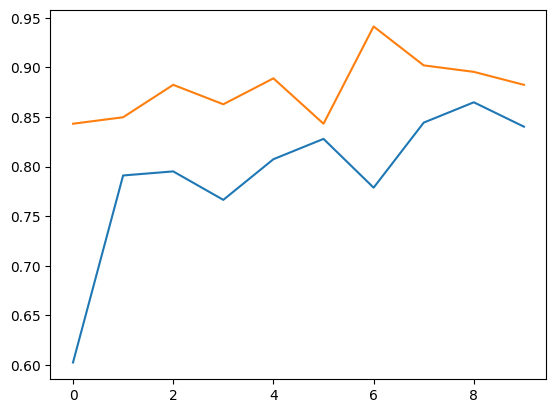

In [23]:
# Assuming running_corrects_history is a list of PyTorch tensors
# Convert and move tensors to CPU and then convert to NumPy arrays
running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]
test_running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in val_running_corrects_history]

plt.plot(running_corrects_history_numpy, label='accuracy')
plt.plot(test_running_corrects_history_numpy, label='test accuracy')


In [24]:
# # saving the model
# 
# model_path = './trained-models/Transfer-Learning-AlexNet'
# torch.save(model.state_dict(), model_path)

In [25]:
# loading the model
# model = LeNet().to(device)
# model_path = './trained-model/first-model'
# model.load_state_dict(torch.load(model_path))

In [26]:
# import requests
# from PIL import Image
# import PIL.ImageOps
# 
# url = ''
# 
# response = requests.get(url, stream=True)
# img = Image.open(response.raw)
# 
# img = transform(img)
# plt.imshow(im_convert(img))

In [27]:
# image = img.to(device).unsqueeze(0)
# 
# test_outputs = model(image)
# _, pred = torch.max(test_outputs, 1)
# print(classes[pred.item()])

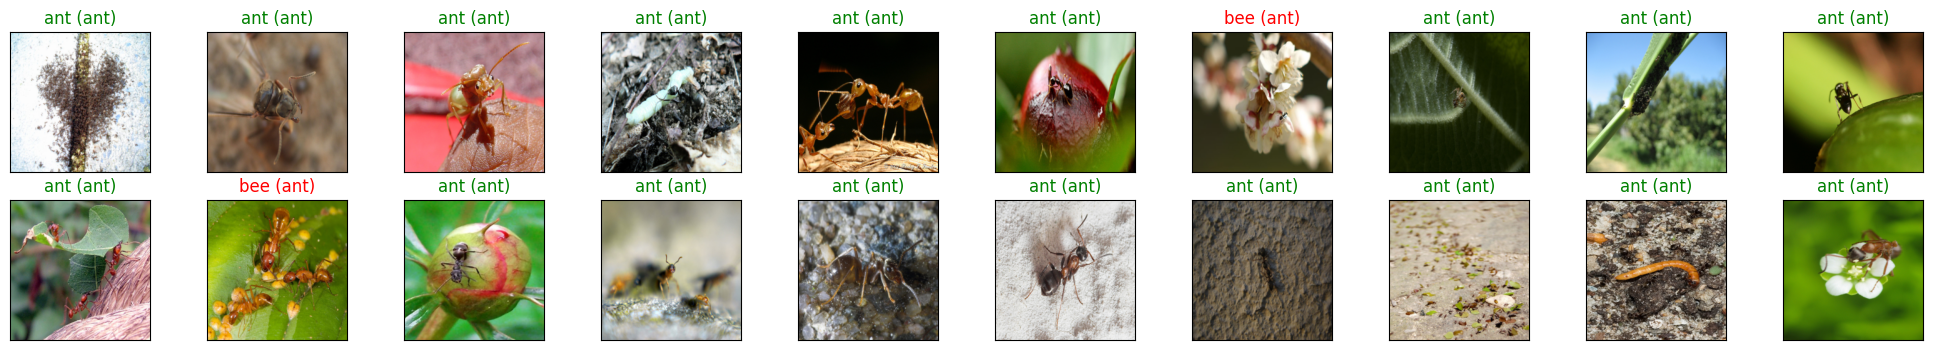

In [28]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

# running_corrects_history_numpy = [tensor.cpu().numpy() for tensor in running_corrects_history]


for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(
        "{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])),
        color=('green' if preds[idx] == labels[idx] else "red"))